In [2]:
#shenanigans so python finds weak_sauce module 
import sys
sys.path.append('/u/ki/mbaumer/random_pixel_size/weak_sauce/code')
print(sys.path)

['', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pIDLy-0.2.4-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pexpect-2.4-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pywcsgrid2-0.1b2-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/CosmoloPy-0.1.104-py2.7-macosx-10.5-x86_64.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pyobjc-2.5.1-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pyobjc_framework_Social-2.5.1-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pyobjc_framework_EventKit-2.5.1-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pyobjc_framework_Accounts-2.5.1-py2.7.egg', '/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pyobjc_frame

In [45]:
%matplotlib inline
import weak_sauce as ws
import weak_sauce.data_tools
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from weak_sauce.movers import UniformGaussianMover
from weak_sauce.grid import MoveableGrid
from weak_sauce.sources import Source
from weak_sauce.movers import UniformIlluminationMover, FixedIlluminationMover
from weak_sauce.fit_flat import FlatFitter

def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
    
import galsim

In [47]:
src1 = Source(num_x=51,flux_func=gauss,sigma=3)
test_galsim = galsim.Gaussian(sigma=3,flux=3)
src2 = Source(num_x=51,flux_func=test_galsim)
src1.plot_pixel_grid()
src2.plot_pixel_grid()
src1.plot(src1.fluxes-src2.fluxes)

TypeError: bounds must be a galsim.BoundsI instance

So the galsim gaussian object (with flux=3) matches the hand-coded gaussian flux_func to 1 part in 10^17, so we're good!

##Alternative to flux measured by AdaptiveMoments: photutils

In [5]:
test_gauss = galsim.Gaussian(sigma=3,flux=2)
test_gauss = test_gauss.shift(15,15)
phot_src = Source(num_x=51,flux_func=test_gauss)

(<matplotlib.figure.Figure at 0x1176e2650>,
 <matplotlib.axes.AxesSubplot at 0x11763ca90>)

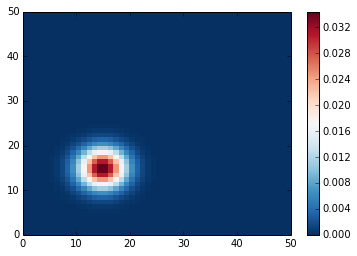

In [6]:
phot_src.plot_pixel_grid()

In [8]:
res = phot_src.evaluate_psf()
print(res[['flux','Mx','My','e1','e2']])
np.sum(phot_src.fluxes)

   flux    Mx    My            e1            e2
0     1  14.5  14.5 -4.350945e-10  9.596366e-12


1.9999989817297581

For some reason, the flux measured by adaptive moments is half the sum over all the pixels...but whatever; let's press on

photutils seems interesting, but I'm not sure how many people will belive the numbers...let's go with sextractor for now. pysex is really old and poorly documented, but I can make sewpy do what I want with only a few extra lines...

In [9]:
phot_src.evaluate_sex()

ImportError: No module named sewpy

In [14]:
from photutils import CircularAperture
from photutils import aperture_photometry
apertures = CircularAperture((res['Mx'],res['My']), r=9.)
phot_table = aperture_photometry(phot_src.fluxes, apertures)
print phot_table

 aperture_sum  xcenter [1]   ycenter [1] 
                                         
------------- ------------- -------------
1.97702425595 14.4999999987 14.4999999997


In [21]:
def sexArray(img):
    """
    Run sextractor on a numpy array (or weak_sauce source) to do photometry.
    """
    import sewpy, os
    sew = sewpy.SEW(params=["X_IMAGE", "Y_IMAGE", "FLUX_AUTO" , "FLUX_ISO", "FLUX_ISOCOR", "FLAGS"],
            config={"DETECT_MINAREA":10, "PHOT_FLUXFRAC":"0.3, 0.5, 0.8"}, sexpath='/afs/slac/g/ki/software/local/bin/sex')
    from astropy.io import fits
    if type(img) == eval('np.ndarray'):
        hdu = fits.PrimaryHDU(img)
    elif hasattr(img,'fluxes'):
        hdu = fits.PrimaryHDU(img.fluxes)
    else:
        raise TypeError('img should be either an numpy array or a weak_sauce source')
    hdulist = fits.HDUList([hdu])
    hdulist.writeto('temp.fits',clobber=True)
    out = sew('temp.fits')
    os.remove('temp.fits')
    return out["table"] # this is an astropy table.

##Testing galsim science impact edge cases

In [5]:
from weak_sauce.adaptive_moments.psf_evaluator import Moment_Evaluator

full_amp_img = np.load('../data/lsst_ultraflat_75ke_amp3.npy')
fitted = ws.data_tools.fitIlluminationVariation(full_amp_img)
data_rel_flux_map = (full_amp_img-fitted)/fitted+1
data_rel_flux_map = data_rel_flux_map[1000:1050,200:250]


n_verts_x = 51

In [12]:
np.save('7th_order_LSST_50x50',data_rel_flux_map)

In [10]:
obj = galsim.Gaussian(sigma=3)
obj = obj.shift(25,25)
obj = obj.shear(e=.1,beta=galsim.Angle(20,galsim.degrees))

In [22]:
stationary_source = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, \
                                           flux_func=obj)
print sexArray(stationary_source.fluxes)
print stationary_source.evaluate_psf()['flux']

X_IMAGE Y_IMAGE FLUX_AUTO FLUX_ISO FLUX_ISOCOR FLAGS
  pix     pix       ct       ct         ct          
------- ------- --------- -------- ----------- -----
124.884 134.496  24.94639       25          25     8
0    12.5
Name: flux, dtype: float64


In [10]:
%%writefile gridScienceImpact.py
def doGridAna(param_vec):
    import pandas as pd
    import copy
    import numpy as np
    from weak_sauce.grid import MoveableGrid
    from weak_sauce.sources import Source
    from weak_sauce.movers import FixedIlluminationMover
    
    n_verts_x = 51
    
    saved_mg = MoveableGrid('../data/test100k_iter.pkl')
    #flat=np.load('../data/data_rel_flux_map_50x50.npy')
    flat=data_rel_flux_map
    
    res_df_list = []
    ideal_df_list = []
    
    for params in param_vec:
        res_df = pd.DataFrame()
        ideal_df = pd.DataFrame()
        for xctr in np.arange(23,25):
            for yctr in np.arange(23,25):
                #params: e, sigma, theta
                obj = galsim.Gaussian(fwhm=params[1])
                obj = obj.shift(xctr,yctr)
                obj = obj.shear(e=params[0],beta=galsim.Angle(params[2],galsim.degrees))
                temp = copy.deepcopy(saved_mg)
                #source should be oversampled wrt pixels; hence the 5x
                stationary_source = Source(num_x=5*(n_verts_x-1)+1, min_x=0, max_x=50, \
                                           flux_func=obj)
                #stationary_source = Source(num_x=n_verts_x, flux_func=gauss, mu=(xctr,yctr),sigma=3) #non-oversampled
                illuminator = FixedIlluminationMover(stationary_source)

                ideal_grid = Source(num_x=n_verts_x)
                ideal_mg = MoveableGrid(ideal_grid,illuminator)
                ideal_mg.step()
                ideal_res = ideal_mg.evaluate_psf()
                ideal_df = ideal_df.append(ideal_res)

                temp.source.fluxes -= 1
                temp.source.psf_evaluator = Moment_Evaluator(num_iter_max = 1000)
                mg = MoveableGrid(temp.source, illuminator)
                mg.step()
                mg.source.fluxes /= flat
                fitted_res = mg.evaluate_psf()
                res_df = res_df.append(fitted_res)
        res_df["inputE"] = params[0]
        res_df["inputS"] = params[1]
        res_df["inputTheta"] = params[2]
        ideal_df["inputE"] = params[0]
        ideal_df["inputS"] = params[1]
        ideal_df["inputTheta"] = params[2]
        res_df_list.append(res_df)
        ideal_df_list.append(ideal_df)
    return res_df_list, ideal_df_list

Writing gridScienceImpact.py


In [8]:
param_vec = [(0,3,30),(.3,4,50)]

In [9]:
D1,D2 = doGridAna(param_vec)

In [53]:
import pandas as pd
pd.concat(D1)

,Mx,Mxx,Mxy,My,Myy,a4,delta1,delta2,e0,e0prime,...,x3,xy,xy2,y2,y3,zeta1,zeta2,inputE,inputS,inputTheta
0,22.500177,1.707082,0.001490,22.499910,1.703861,-0.000482,0.000015,-0.000023,0.124329,0.248658,...,-0.000454,0.000745,-0.000408,0.851930,0.000526,-0.000017,0.000006,0.0,3,30
0,23.500575,1.704392,0.000927,22.500293,1.704078,-0.000103,-0.000046,-0.000020,0.124239,0.248477,...,-0.000830,0.000464,0.000497,0.852039,0.000747,-0.000007,0.000013,0.0,3,30
0,22.500435,1.707690,0.000070,23.499602,1.703224,0.000217,0.000028,0.000051,0.124328,0.248655,...,0.000071,0.000035,-0.000452,0.851612,-0.001234,-0.000007,-0.000016,0.0,3,30
0,23.501017,1.705290,0.001642,23.499924,1.703425,-0.000253,-0.000051,0.000070,0.124248,0.248495,...,-0.000594,0.000821,0.000673,0.851712,-0.001060,0.000002,-0.000004,0.0,3,30
0,26.914418,3.263758,0.897306,25.674796,2.948200,-0.000403,0.000022,-0.000021,0.226426,0.442892,...,0.006669,0.448653,0.001856,1.474100,0.001387,0.000168,0.000029,0.3,4,50
0,27.953973,3.271831,0.895585,25.828128,2.949634,-0.001507,-0.000073,-0.000142,0.226772,0.443625,...,-0.000166,0.447793,0.001177,1.474817,0.000709,0.000020,-0.000029,0.3,4,50
0,27.067978,3.263310,0.899791,26.659715,2.949767,0.000096,0.000138,-0.000014,0.226467,0.442924,...,0.005158,0.449895,-0.000624,1.474884,0.000290,0.000089,0.000003,0.3,4,50
0,28.107254,3.268642,0.897421,26.813317,2.948831,-0.000478,0.000037,-0.000188,0.226627,0.443292,...,-0.000886,0.448710,-0.000921,1.474416,-0.000845,-0.000036,-0.000085,0.3,4,50
